In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/keras-pretrained-models/imagenet_class_index.json
/kaggle/input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/keras-pretrained-models/Kuszma.JPG
/kaggle/input/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv
/kagg

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import os

In [3]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [4]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
print(left_cataract[:10])
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
print(right_cataract[:15])

['0_left.jpg' '81_left.jpg' '103_left.jpg' '119_left.jpg' '254_left.jpg'
 '294_left.jpg' '330_left.jpg' '448_left.jpg' '465_left.jpg'
 '477_left.jpg']
['24_right.jpg' '81_right.jpg' '112_right.jpg' '188_right.jpg'
 '218_right.jpg' '345_right.jpg' '354_right.jpg' '477_right.jpg'
 '553_right.jpg' '560_right.jpg' '625_right.jpg' '726_right.jpg'
 '769_right.jpg' '949_right.jpg' '955_right.jpg']


In [5]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [6]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [7]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [8]:
print(len(cataract),len(normal))

594 600


In [9]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [10]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [00:06<00:00, 96.99it/s] 


In [11]:
len(dataset)

588

In [12]:
dataset = create_dataset(normal,0)

100%|██████████| 600/600 [00:08<00:00, 71.67it/s]


In [13]:
len(dataset)

1188

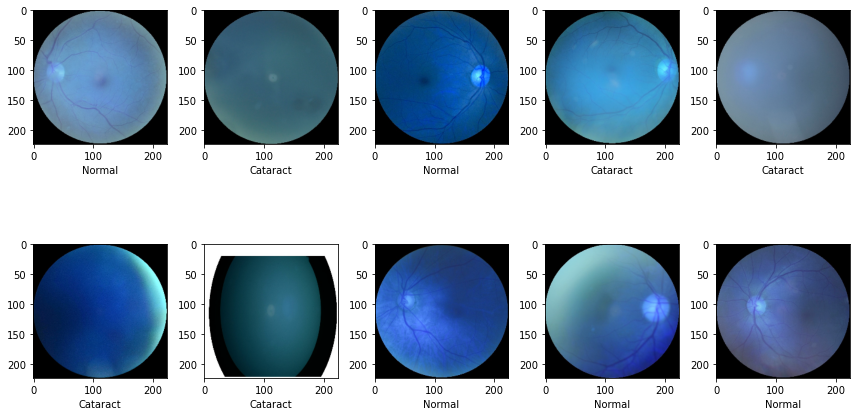

In [14]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [15]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [17]:
from keras.applications.vgg16 import VGG16, preprocess_input
vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=(224,224,3)
)

In [18]:
for layer in vgg.layers:
    layer.trainable = False

In [19]:
from tensorflow.keras import Sequential
from keras import layers
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(Dense(128, activation='sigmoid'))
model.add(layers.Dropout(rate=0.2))
model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dense (Dense)                (None, 7, 7, 256)         131328    
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 128)         32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
dense_2 (Dense)              (None, 7, 7, 128)         16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0

In [21]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])


In [22]:
history = model.fit(x_train,y_train,batch_size=32,epochs=20,validation_data=(x_test,y_test))

Epoch 1/20
30/30 [==============================] - 221s 7s/step - loss: 0.4040 - accuracy: 0.8158 - val_loss: 0.2035 - val_accuracy: 0.9244
Epoch 2/20
30/30 [==============================] - 210s 7s/step - loss: 0.1869 - accuracy: 0.9421 - val_loss: 0.1619 - val_accuracy: 0.9370
Epoch 3/20
30/30 [==============================] - 224s 7s/step - loss: 0.1612 - accuracy: 0.9432 - val_loss: 0.1864 - val_accuracy: 0.9286
Epoch 4/20
30/30 [==============================] - 211s 7s/step - loss: 0.1479 - accuracy: 0.9484 - val_loss: 0.1329 - val_accuracy: 0.9412
Epoch 5/20
30/30 [==============================] - 211s 7s/step - loss: 0.1170 - accuracy: 0.9663 - val_loss: 0.1382 - val_accuracy: 0.9454
Epoch 6/20
30/30 [==============================] - 225s 8s/step - loss: 0.0986 - accuracy: 0.9695 - val_loss: 0.1103 - val_accuracy: 0.9538
Epoch 7/20
30/30 [==============================] - 211s 7s/step - loss: 0.0635 - accuracy: 0.9789 - val_loss: 0.1053 - val_accuracy: 0.9580
Epoch 8/20
30

In [23]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict_classes(x_test)

In [24]:
accuracy_score(y_test,y_pred)

0.9705882352941176

In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       122
           1       0.94      1.00      0.97       116

    accuracy                           0.97       238
   macro avg       0.97      0.97      0.97       238
weighted avg       0.97      0.97      0.97       238

